In [40]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

**Preprocessing Step**

In [41]:
scraped_data_folder = "scraped_data_merged"
processed_data_folder = "processed_data"

1. process the players data

In [42]:
# read the CSV file containing players data
players_df = pd.read_csv(f'{scraped_data_folder}/all_players_data.csv')
players_df.head()

,player,current_value,main_position,other_positions,nationality,date_of_birth,city_of_birth,country_of_birth,height,current_club,contract_expires,on_loan_from,contract_there_expires,number,foot,outfitter
0,Jude Bellingham,€180.00m,Attacking Midfield,['Central Midfield'],England,"Jun 29, 2003 (20)",Stourbridge,England,"1,86 m",Real Madrid,30-Jun-29,-,-,#5,right,adidas
1,Erling Haaland,€180.00m,Centre-Forward,[],Norway,"Jul 21, 2000 (23)",Leeds,England,"1,95 m",Manchester City,30-Jun-27,-,-,#9,left,Nike
2,Kylian Mbappé,€180.00m,Centre-Forward,"['Left Winger', 'Right Winger']",France,"Dec 20, 1998 (25)",Paris,France,"1,78 m",Paris Saint-Germain,30-Jun-24,-,-,#7,right,Nike
3,Vinícius Júnior,€150.00m,Left Winger,"['Centre-Forward', 'Right Winger']",Brazil,"Jul 12, 2000 (23)",São Gonçalo,Brazil,"1,76 m",Real Madrid,30-Jun-27,-,-,#7,right,Nike
4,Bukayo Saka,€130.00m,Right Winger,"['Left Winger', 'Right Midfield']",England,"Sep 5, 2001 (22)",London,England,"1,78 m",Arsenal FC,30-Jun-27,-,-,#7,left,New Balance


check for columns data types

stes:
       a. conversions of data types
       b. clean "str" values and convert them to relevant data type

In [43]:
print(players_df.dtypes)

player                    object
current_value             object
main_position             object
other_positions           object
nationality               object
date_of_birth             object
city_of_birth             object
country_of_birth          object
height                    object
current_club              object
contract_expires          object
on_loan_from              object
contract_there_expires    object
number                    object
foot                      object
outfitter                 object
dtype: object


data types convertions of market_value, height, conract_dates, date_of_birth,

In [44]:
def convert_market_value_to_float(df, column_name):
    # Remove euro symbol and 'm' suffix, and convert to int
    for index, row in df.iterrows():
         if isinstance(row[column_name], str):
            if 'k' in row[column_name]:
                row[column_name] = float(row[column_name].replace('€', '').replace('k', '')) / 1000
            else:
                row[column_name] = float(row[column_name].replace('€', '').replace('m', ''))
    df[column_name] = df[column_name].astype(float)


convert_market_value_to_float(players_df, 'current_value')
# check if it was done correctly
print(players_df['current_value'])

0      180.0
1      180.0
2      180.0
3      150.0
4      130.0
       ...  
495     20.0
496     20.0
497     20.0
498     20.0
499     20.0
Name: current_value, Length: 500, dtype: float64


In [45]:
def convert_height_to_float(df, column_name):
    # Replace comma with dot and convert to float
    df[column_name] = df[column_name].str.replace(',', '.').str.replace('m', '').astype(float)
    df[column_name] = df[column_name] * 100
    df[column_name] = df[column_name].astype(int)

convert_height_to_float(players_df, 'height')
# check if it was done correctly
print(players_df['height'])

0      186
1      195
2      178
3      176
4      178
      ... 
495    170
496    195
497    180
498    174
499    182
Name: height, Length: 500, dtype: int32


In [46]:
# convert to date type
def process_contract_expires(df, column_name):

    df[column_name] = df[column_name].apply(lambda x: None if x == "-" else x)


    date_formats = ["%b %d, %Y", "%d-%b-%y"]

    for fmt in date_formats:
        try:
            df[column_name] = df[column_name].apply(lambda x: datetime.strptime(x, fmt) if x else None)
            break  # stop trying once successful
        except ValueError:
            pass  # continue trying other formats if this one fails


process_contract_expires(players_df, 'contract_expires')
process_contract_expires(players_df, 'contract_there_expires')
print(players_df['contract_expires'])

0     2029-06-30
1     2027-06-30
2     2024-06-30
3     2027-06-30
4     2027-06-30
         ...    
495   2028-06-30
496   2027-06-30
497   2028-06-30
498   2027-06-30
499   2026-06-30
Name: contract_expires, Length: 500, dtype: datetime64[ns]


In [47]:
def parse_date(date_str):
    pattern = r"(\w{3}\s+\d{1,2},\s+\d{4})"
    match = re.search(pattern, date_str)
    if match:
        date_part = match.group(1)
        return datetime.strptime(date_part, "%b %d, %Y")
    else:
        return None

players_df['date_of_birth'] = players_df['date_of_birth'].apply(parse_date)
print(players_df['date_of_birth'])

0     2003-06-29
1     2000-07-21
2     1998-12-20
3     2000-07-12
4     2001-09-05
         ...    
495   1999-06-17
496   1998-02-14
497   1999-08-01
498   1999-05-10
499   1996-01-21
Name: date_of_birth, Length: 500, dtype: datetime64[ns]


In [48]:
# calculate age based on current date and date of birth
current_date = datetime.now()
players_df['age'] = current_date.year - players_df['date_of_birth'].dt.year
print(players_df['age'])

0      21
1      24
2      26
3      24
4      23
       ..
495    25
496    26
497    25
498    25
499    28
Name: age, Length: 500, dtype: int64


In [49]:
players_df['number'] = players_df['number'].str.replace('#', '').astype(int)
print(players_df['number'])

0       5
1       9
2       7
3       7
4       7
       ..
495     7
496    16
497    14
498    53
499    11
Name: number, Length: 500, dtype: int32


remove the "-" from the the main position column

b. clean "str" values and convert them to relevant data type

In [50]:
players_df["main_position"] = players_df["main_position"].str.replace("-", " ")
print(players_df["main_position"].unique())

['Attacking Midfield' 'Centre Forward' 'Left Winger' 'Right Winger'
 'Defensive Midfield' 'Central Midfield' 'Second Striker' 'Centre Back'
 'Right Back' 'Left Back' 'Right Midfield' 'Goalkeeper' 'Left Midfield']


convert the str with the "[]" of the other positions

In [51]:
print(players_df['other_positions'])
# convert list of other positions to a string
players_df['other_positions'] = players_df['other_positions'].apply(lambda x: ast.literal_eval(x) if x != '[]' else x)
players_df['other_positions'] = players_df['other_positions'].apply(lambda x: ', '.join(x) if x!='[]' else '')

print(type(players_df.iloc[0,3]))
print(players_df['other_positions'])

0                       ['Central Midfield']
1                                         []
2            ['Left Winger', 'Right Winger']
3         ['Centre-Forward', 'Right Winger']
4          ['Left Winger', 'Right Midfield']
                       ...                  
495       ['Right Winger', 'Second Striker']
496                     ['Central Midfield']
497        ['Second Striker', 'Left Winger']
498     ['Right Winger', 'Central Midfield']
499    ['Left Winger', 'Attacking Midfield']
Name: other_positions, Length: 500, dtype: object
<class 'str'>
0                     Central Midfield
1                                     
2            Left Winger, Right Winger
3         Centre-Forward, Right Winger
4          Left Winger, Right Midfield
                    ...               
495       Right Winger, Second Striker
496                   Central Midfield
497        Second Striker, Left Winger
498     Right Winger, Central Midfield
499    Left Winger, Attacking Midfield
Name: other_

In [52]:
players_df.to_csv(f'{processed_data_folder}/players_data_processed.csv', index=False, encoding='utf-8-sig')

2. Process the transfers data

In [53]:

data_list = pd.read_json(f'{scraped_data_folder}/all_transfers_data.json')

df = pd.DataFrame(data_list)
df.to_csv('all_transfers_data.csv', index=False, encoding='utf-8-sig')
df_all_transfers = pd.read_csv(f'{scraped_data_folder}/all_transfers_data.csv')
print(f"columns: {df_all_transfers.columns}")

columns: Index(['Player', 'Season', 'From Club', 'To Club', 'Market Value',
       'Transfer Fee'],
      dtype='object')


 steps:
    a. modify column names
    b. process the from_club and to_club columns
    c. process the market_value and transfer_fee columns
    d. split into loan and transfers

convert the columns names

In [54]:
new_column_names = {
    "Player": "player",
    "Season": "season",
    "From Club": "from_club",
    "To Club": "to_club",
    "Market Value": "market_value",
    "Transfer Fee": "transfer_fee"
}

df_all_transfers = df_all_transfers.rename(columns=new_column_names)

b. process the from_club and to_club columns
    remove transfers within the same team between group ages in youth career

In [55]:
def is_within_same_team(row):
    from_club = row['from_club']
    to_club = row['to_club']

    pattern_under = r"\s+(?=U|Youth|Yth|B)"
    splited_values_to_club = re.split(pattern_under, to_club)
    splited_values_from_club = re.split(pattern_under, from_club)
    if (splited_values_to_club[0] in splited_values_from_club[0]) or (splited_values_from_club[0] in splited_values_to_club[0]) :   # moved to U in the same team
        return True

    return False
df_all_transfers = df_all_transfers.drop(df_all_transfers[df_all_transfers.apply(is_within_same_team, axis=1)].index)
df_all_transfers

,player,season,from_club,to_club,market_value,transfer_fee
0,Jude Bellingham,23/24,Bor. Dortmund,Real Madrid,€120.00m,€103.00m
1,Jude Bellingham,20/21,Birmingham,Bor. Dortmund,€11.00m,€30.15m
3,Erling Haaland,22/23,Bor. Dortmund,Man City,€150.00m,€60.00m
4,Erling Haaland,19/20,RB Salzburg,Bor. Dortmund,€45.00m,€20.00m
5,Erling Haaland,18/19,Molde FK,RB Salzburg,€5.00m,€8.00m
...,...,...,...,...,...,...
3121,Sebastian Szymanski,12/13,AP TOP-54 Yth.,Legia Yth.,-,free transfer
3122,Marco Asensio,23/24,Real Madrid,Paris SG,€25.00m,free transfer
3123,Marco Asensio,15/16,Espanyol,Real Madrid,€8.00m,End of loan
3124,Marco Asensio,15/16,Real Madrid,Espanyol,€3.50m,loan transfer


c. process the market_value and transfer_fee columns
    check different values in the market_value and transfer_fee and replace them

In [56]:
print(f"market_value unique values:")
for value in df_all_transfers["market_value"].unique():
    if not any(char.isdigit() for char in value):
        print(value)

market_value unique values:
-


In [57]:
df_all_transfers['market_value'] = df_all_transfers['market_value'].replace('-', 0.0)
convert_market_value_to_float(df_all_transfers, "market_value")

In [58]:
print(f"transfer_fee unique values:")
for value in df_all_transfers["transfer_fee"].unique():
    if not any(char.isdigit() for char in value):
        print(value)

transfer_fee unique values:
End of loan
loan transfer
free transfer
-
?
draft


In [59]:
df_all_transfers['transfer_fee'] = df_all_transfers['transfer_fee'].replace('-', 0.0)
df_all_transfers['transfer_fee'] = df_all_transfers['transfer_fee'].replace('?', 0.0)
df_all_transfers['transfer_fee'] = df_all_transfers['transfer_fee'].replace('draft', 0.0)
df_all_transfers['transfer_fee'] = df_all_transfers['transfer_fee'].replace("free transfer",0.0)

since the transfers contain both loan and transfers, i want to consider it as two seperated types

In [60]:
# check if "loan fee" or "Loan fee is present in the "Transfer Fee" column
mask = df_all_transfers["transfer_fee"].str.contains("loan fee|Loan fee",case=False, na=False)

# replace the values where the condition is True
df_all_transfers.loc[mask, "transfer_fee"] = "loan transfer"

In [61]:
def convert_transfer_fee_to_float(df):
    for index, row in df.iterrows():
        if isinstance(row["transfer_fee"], str):
            if row["transfer_fee"].lower() == "loan transfer" or row["transfer_fee"].lower() == "end of loan":
                pass
            elif "loan fee" in row["transfer_fee"].lower():
                pass
            elif 'k' in row["transfer_fee"]:
                df.at[index, "transfer_fee"] = float(row["transfer_fee"].replace('€', '').replace('k', '')) / 1000
            elif 'm' in row["transfer_fee"]:
                df.at[index, "transfer_fee"] = float(row["transfer_fee"].replace('€', '').replace('m', ''))
            else:
                # Handle other cases here, if needed
                pass
convert_transfer_fee_to_float(df_all_transfers)


In [62]:
df_all_transfers['season'] = pd.to_datetime(df_all_transfers['season'].apply(lambda x: "20" + x.split("/")[0] if "/" in x else x), format='%Y')
# Convert datetime format to year only
df_all_transfers['season'] = df_all_transfers['season'].dt.strftime('%Y')

d. split into loan and transfers

In [63]:
def split_transfers_and_loans(df):
    # Create DataFrame for transfers and loans
    transfers_df = df[~df["transfer_fee"].str.contains("loan", case=False, na=False)]
    loans_df = df[df["transfer_fee"].str.contains("loan", case=False, na=False)]

    return transfers_df, loans_df

# split the DataFrame
transfers_df, loans_df = split_transfers_and_loans(df_all_transfers)

In [64]:
transfers_df["transfer_fee"] = transfers_df["transfer_fee"].astype(float)
transfers_df.dtypes

player           object
season           object
from_club        object
to_club          object
market_value    float64
transfer_fee    float64
dtype: object

In [65]:
# store the processed df
transfers_df.to_csv(f'{processed_data_folder}/transfers_data_processed.csv', index=False, encoding='utf-8-sig')

keeps processing the loans_df.
    a. each loan has a loan record and return from loan record. so i want to get rid of the return from loan record
    b. there are long term loan so i want to consider them as a renewed loan each season

In [66]:
loans_df

,player,season,from_club,to_club,market_value,transfer_fee
9,Kylian Mbappé,2017,Paris SG,Monaco,120.0,End of loan
10,Kylian Mbappé,2017,Monaco,Paris SG,35.0,loan transfer
37,Victor Osimhen,2018,R Charleroi SC,VfL Wolfsburg,13.0,End of loan
38,Victor Osimhen,2018,VfL Wolfsburg,R Charleroi SC,1.0,loan transfer
53,Harry Kane,2012,Leicester,Tottenham,0.5,End of loan
...,...,...,...,...,...,...
3096,Noa Lang,2019,Ajax,Twente FC,3.0,loan transfer
3115,Sebastian Szymanski,2022,Feyenoord,Dynamo Moscow,18.0,End of loan
3116,Sebastian Szymanski,2022,Dynamo Moscow,Feyenoord,14.0,loan transfer
3123,Marco Asensio,2015,Espanyol,Real Madrid,8.0,End of loan


In [67]:
def process_loan_transfers(df):
    """
    keep only "one way" of a loan transfer
    if long term loan then create another one-year loan
    :param df:
    :return:
    """
    # Step 1: Iterate over the unique players
    rows_to_drop = []
    rows_to_add = []
    for player in df["player"].unique():
        # Step 2: Filter relevant rows for each player
        player_data = df[df["player"] == player].sort_values(by="season")
        for index, row in player_data.iterrows():
            if row["transfer_fee"]=="End of loan":
                if 0<= (int(player_data.loc[index+1,"season"]) - int(row["season"])) <= 1:
                     rows_to_drop.append(index)
                else:
                    start_season = int(player_data.loc[index+1,"season"]) + 1

                    for season in range(start_season, int(row["season"])):
                        new_row = {
                        "player": row["player"],
                        "season": str(season),
                        "from_club": row["to_club"],
                        "to_club": row["from_club"],
                        "market_value":row["market_value"],
                        "transfer_fee": "loan transfer"
                        }
                        rows_to_add.append(new_row)
                    rows_to_drop.append(index)
            else:
                continue
            # Drop rows to be removed

    df = df.drop(rows_to_drop)
    df = df.append(rows_to_add, ignore_index=True)
    return df
loans_df = process_loan_transfers(loans_df)


In [68]:
loans_df

,player,season,from_club,to_club,market_value,transfer_fee
0,Kylian Mbappé,2017,Monaco,Paris SG,35.0,loan transfer
1,Victor Osimhen,2018,VfL Wolfsburg,R Charleroi SC,1.0,loan transfer
2,Harry Kane,2012,Tottenham,Leicester,0.5,loan transfer
3,Harry Kane,2012,Tottenham,Norwich,0.0,loan transfer
4,Harry Kane,2011,Tottenham,Millwall,0.0,loan transfer
...,...,...,...,...,...,...
447,Marco Asensio,2015,Real Madrid,Espanyol,3.5,loan transfer
448,Éderson,2021,Corinthians,Fortaleza,5.0,loan transfer
449,Danilo,2019,PFC Cajazeiras,Palmeiras U20,0.0,loan transfer
450,Jack Harrison,2019,Man City,Leeds,15.0,loan transfer


In [69]:
# check if all values were processed
loans_df["transfer_fee"].unique()

array(['loan transfer'], dtype=object)

In [70]:
loans_df.to_csv(f'{processed_data_folder}/loans_data_processed.csv', index=False, encoding='utf-8-sig')

3. Process the market value development data
    a. create a df from the json file and choose the column names
    b. remove empty values in the market value
    c. convert market value to float
    d. covert date to date object
    e. remove duplicated value that does not give new information

In [71]:
# Load JSON data
with open(f'{scraped_data_folder}/all_mv_data.json', 'r', encoding='utf-8-sig') as file:
    mv_data = json.load(file)

a. create a df from the json file and choose the column names

In [72]:


# Initialize lists to store extracted data
player_data = []

# Iterate over each player in the JSON data
for player_dict in mv_data:

    player_name, player_info = list(player_dict.keys())[0], list(player_dict.values())[0]["list"]
    # Extract data for each entry in the list
    for entry in player_info:
        datum_mw = entry["datum_mw"]
        club = entry["verein"]
        age = entry["age"]
        market_value = entry["mw"]
        wappen = entry["wappen"]

        # Append extracted data to the list
        player_data.append({
            "player": player_name,
            "age": age,
            "date": datum_mw,
            "club": club,
            "market_value": market_value
        })

# Create DataFrame from the extracted data
mv_df = pd.DataFrame(player_data)

print(mv_df.dtypes)

player          object
age             object
date            object
club            object
market_value    object
dtype: object


b. remove empty values in the market value

In [73]:
# Replace "-" with NaN
mv_df["market_value"] = mv_df["market_value"].replace('-', np.nan)

# Drop NaN values
mv_df = mv_df.dropna(subset=['market_value'])

c. convert market value to float

In [74]:
def process_market_value(value):
    if 'k' in value:
        return float(value.replace('€', '').replace('k', '')) / 1000
    else:
        return float(value.replace('€', '').replace('m', ''))

mv_df["market_value"] = mv_df["market_value"].apply(process_market_value)
mv_df["market_value"] = mv_df["market_value"].astype(float)

d. covert date to date object

In [75]:
mv_df['date'] = pd.to_datetime(mv_df['date']).dt.strftime('%b %Y')
mv_df['date'] = pd.to_datetime(mv_df['date'], format='%b %Y')

e. remove duplicated value that does not give new information

In [76]:
# Drop player duplicates with the same age and same market value
mv_df = mv_df.drop_duplicates(subset=["player","age", "market_value"], keep="first")
mv_df['age'] = mv_df['age'].astype(int)

In [77]:
# store the processed df
mv_df.to_csv('mv_data_processed.csv', index=False, encoding='utf-8-sig')

**Analyze Data**

1. market value development among the top_n (parameter) players

In [78]:
# Assuming "player" is the common column between the two DataFrames
mv_with_position = mv_df.merge(players_df[["player", "main_position"]], on="player", how="left")
mv_with_position

,player,age,date,club,market_value,main_position
0,Jude Bellingham,16,2019-10-01,Birmingham City,2.5,Attacking Midfield
1,Jude Bellingham,16,2020-02-01,Birmingham City,12.0,Attacking Midfield
2,Jude Bellingham,16,2020-04-01,Birmingham City,11.0,Attacking Midfield
3,Jude Bellingham,17,2020-09-01,Borussia Dortmund,27.0,Attacking Midfield
4,Jude Bellingham,17,2021-02-01,Borussia Dortmund,35.0,Attacking Midfield
...,...,...,...,...,...,...
8165,Marco Asensio,26,2022-06-01,Real Madrid,40.0,Right Winger
8166,Marco Asensio,26,2022-09-01,Real Madrid,35.0,Right Winger
8167,Marco Asensio,26,2022-11-01,Real Madrid,25.0,Right Winger
8168,Marco Asensio,27,2023-06-01,Real Madrid,25.0,Right Winger


In [79]:
mv_df

,player,age,date,club,market_value
0,Jude Bellingham,16,2019-10-01,Birmingham City,2.5
1,Jude Bellingham,16,2020-02-01,Birmingham City,12.0
2,Jude Bellingham,16,2020-04-01,Birmingham City,11.0
3,Jude Bellingham,17,2020-09-01,Borussia Dortmund,27.0
4,Jude Bellingham,17,2021-02-01,Borussia Dortmund,35.0
...,...,...,...,...,...
9605,Marco Asensio,26,2022-06-01,Real Madrid,40.0
9606,Marco Asensio,26,2022-09-01,Real Madrid,35.0
9607,Marco Asensio,26,2022-11-01,Real Madrid,25.0
9608,Marco Asensio,27,2023-06-01,Real Madrid,25.0


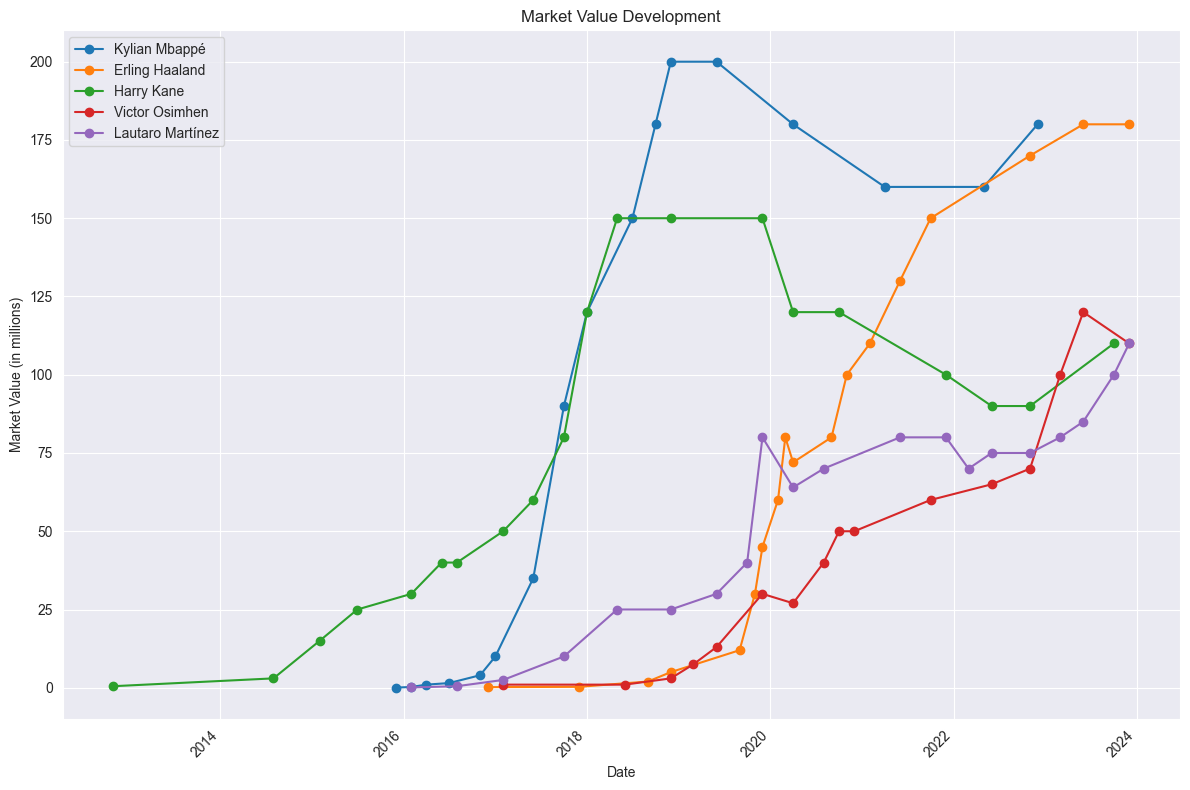

In [80]:
def plot_market_value_development(df, player_names=[], positions=[], top=5):
    # Filter the dataframe based on player names and positions
    if player_names:
        filtered_df = df[df['player'].isin(player_names)]
    elif positions:
        filtered_df = df[df['main_position'].isin(positions)]
    else:
        filtered_df = df.copy()

    # Get the latest row for each player
    latest_rows = filtered_df.sort_values('date').groupby('player').tail(1)

    # Get the top players by maximal market value among their latest row
    top_players = latest_rows.nlargest(top, 'market_value')['player']

    # Plot the market values of each player
    plt.figure(figsize=(12, 8))
    for player in top_players:
        player_data = filtered_df[filtered_df['player'] == player].sort_values('date')
        plt.plot(player_data['date'], player_data['market_value'], marker='o', label=player)

    plt.title('Market Value Development')
    plt.xlabel('Date')
    plt.ylabel('Market Value (in millions)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_market_value_development(mv_with_position,positions= ["Centre Forward"] ,top=5)

In [81]:
print(f"loan_df : {loans_df.columns}")
print(f"transfers_df : {transfers_df.columns}")
print(f"mv_df : {mv_df.columns}")
print(f"players_df : {players_df.columns}")

loan_df : Index(['player', 'season', 'from_club', 'to_club', 'market_value',
       'transfer_fee'],
      dtype='object')
transfers_df : Index(['player', 'season', 'from_club', 'to_club', 'market_value',
       'transfer_fee'],
      dtype='object')
mv_df : Index(['player', 'age', 'date', 'club', 'market_value'], dtype='object')
players_df : Index(['player', 'current_value', 'main_position', 'other_positions',
       'nationality', 'date_of_birth', 'city_of_birth', 'country_of_birth',
       'height', 'current_club', 'contract_expires', 'on_loan_from',
       'contract_there_expires', 'number', 'foot', 'outfitter', 'age'],
      dtype='object')


2. total transfers spending in each season

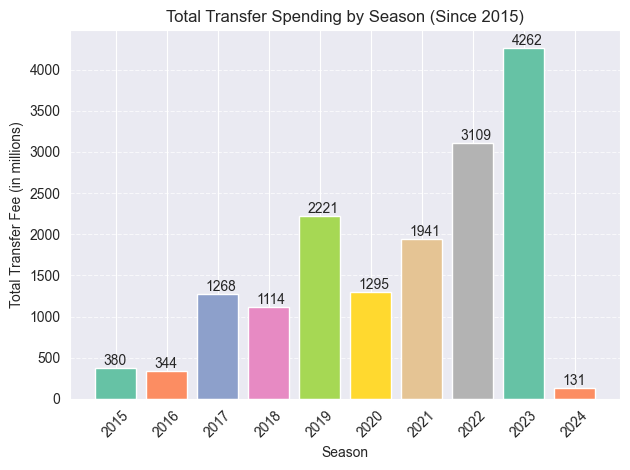

In [82]:
def total_spending_over_years(start_year):
    transfers_by_season = transfers_df.groupby('season')['transfer_fee'].sum().reset_index()
    transfers_by_season_since_year = transfers_by_season[transfers_by_season['season'] >= start_year]

    colors = sns.color_palette('Set2', len(transfers_by_season_since_year))  # You can change
    fix, ax = plt.subplots()
    bars = ax.bar(transfers_by_season_since_year['season'], transfers_by_season_since_year['transfer_fee'], color = colors)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 5, yval, int(yval), va='bottom')


    ax.set_title(f'Total Transfer Spending by Season (Since {start_year})')
    ax.set_xlabel('Season')
    ax.set_ylabel('Total Transfer Fee (in millions)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
total_spending_over_years(start_year="2015")

3. Comparison of market value between the players main position (determine top n players to look over)

In [83]:
print(players_df["main_position"].unique())

['Attacking Midfield' 'Centre Forward' 'Left Winger' 'Right Winger'
 'Defensive Midfield' 'Central Midfield' 'Second Striker' 'Centre Back'
 'Right Back' 'Left Back' 'Right Midfield' 'Goalkeeper' 'Left Midfield']


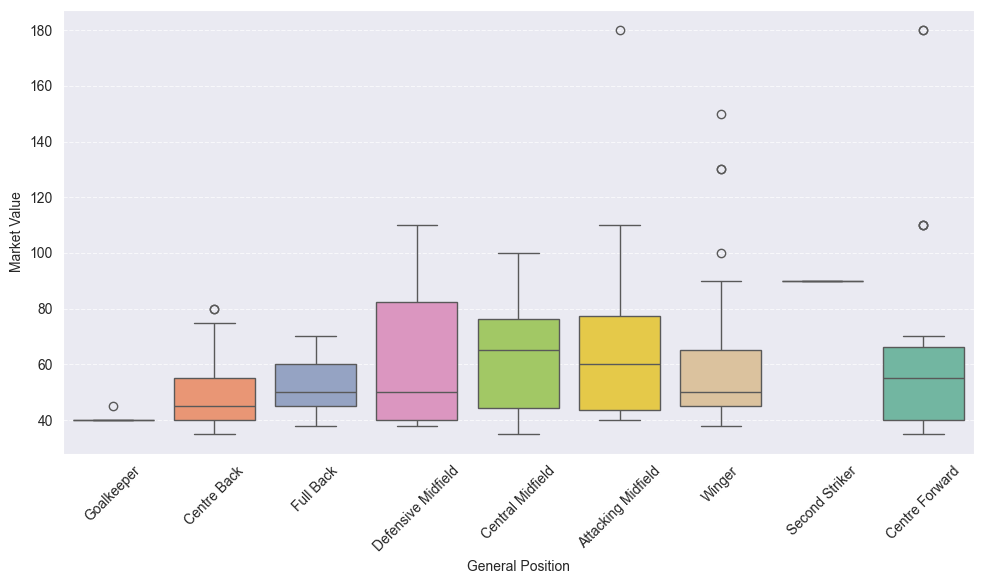

In [84]:
def generalize_positions(row):
    if 'Winger' in row['main_position'] or row['main_position'] == 'Right Midfield' or row['main_position'] == 'Left Midfield' :
        return 'Winger'
    elif row['main_position'] == 'Right Back' or row['main_position'] == 'Left Back'  :
        return 'Full Back'
    else:
        return row['main_position']
def compare_mv_across_positions(top_n = 100):
    top_n_players = players_df.iloc[:top_n]
    top_n_players["general_position"] = top_n_players.apply(generalize_positions, axis=1)

    position_order = ['Goalkeeper','Centre Back', 'Full Back','Defensive Midfield', 'Central Midfield','Attacking Midfield', 'Winger','Second Striker','Centre Forward']

    plt.figure(figsize=(10, 6))
    plt.xlabel('General Position')
    plt.ylabel('Market Value')
    sns.set(style="whitegrid")
    sns.boxplot(x="general_position", y="current_value", data=top_n_players, palette="Set2", order=position_order)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
top_n = 200
compare_mv_across_positions(top_n=top_n)


4. comparison of market value between the positions (top n players in each position)

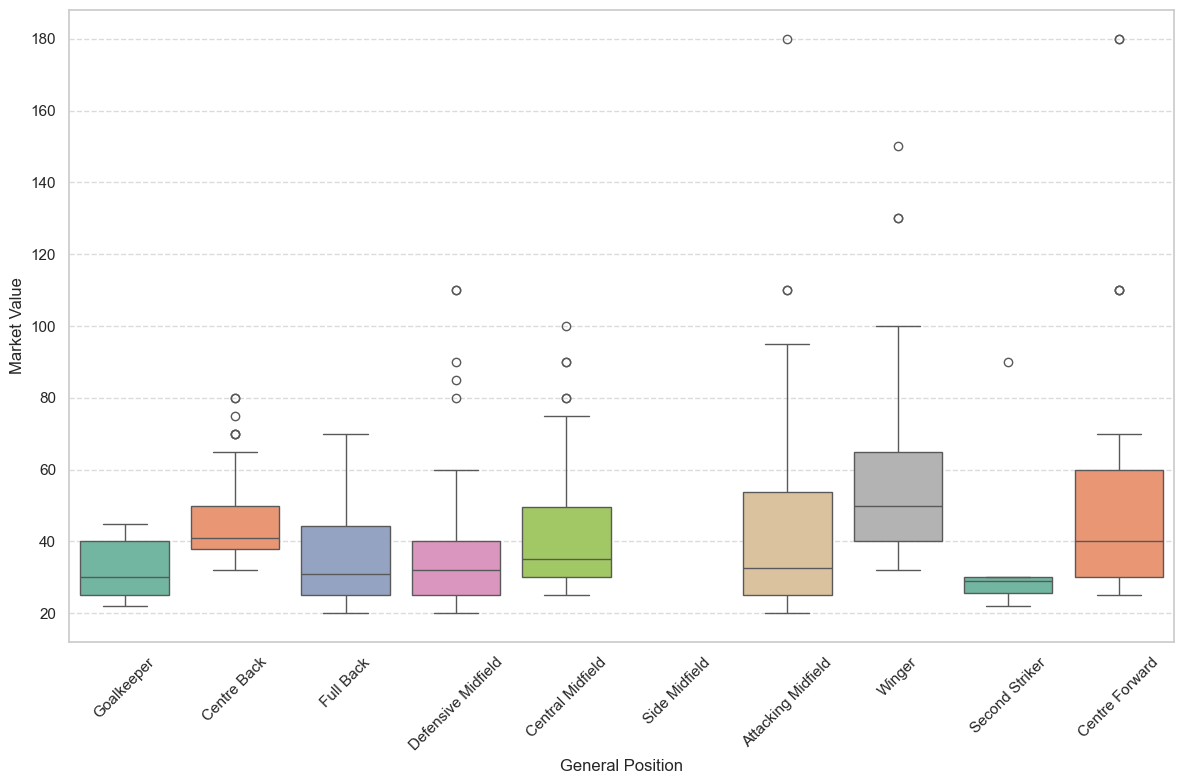

In [85]:

def get_top_n_players_by_position(df, n):
    top_n_players = pd.DataFrame()
    df['general_position'] = df.apply(generalize_positions, axis=1)
    for position in df['general_position'].unique():
        top_players = df[df['general_position'] == position].nlargest(n, 'current_value')
        top_n_players = pd.concat([top_n_players, top_players])
    return top_n_players


def compare_mv_across_positions(top_n_players):
    position_order = ['Goalkeeper', 'Centre Back', 'Full Back', 'Defensive Midfield', 'Central Midfield', 'Side Midfield', 'Attacking Midfield', 'Winger', 'Second Striker', 'Centre Forward']

    plt.figure(figsize=(12, 8))
    plt.xlabel('General Position')
    plt.ylabel('Market Value')
    sns.set(style="whitegrid")
    sns.boxplot(x="general_position", y="current_value", data=top_n_players, palette="Set2", order=position_order)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

n = 50
top_n_players = get_top_n_players_by_position(players_df, n)

compare_mv_across_positions(top_n_players)


5. correalation between market value and transfer fee

In [86]:

correlation = transfers_df['transfer_fee'].corr(transfers_df['market_value'])
print(f"Correlation between transfer fee and market value: {correlation}")

Correlation between transfer fee and market value: 0.85000190660693


6. relative representation of nationalities within the top N players of a chosen position (or all position)

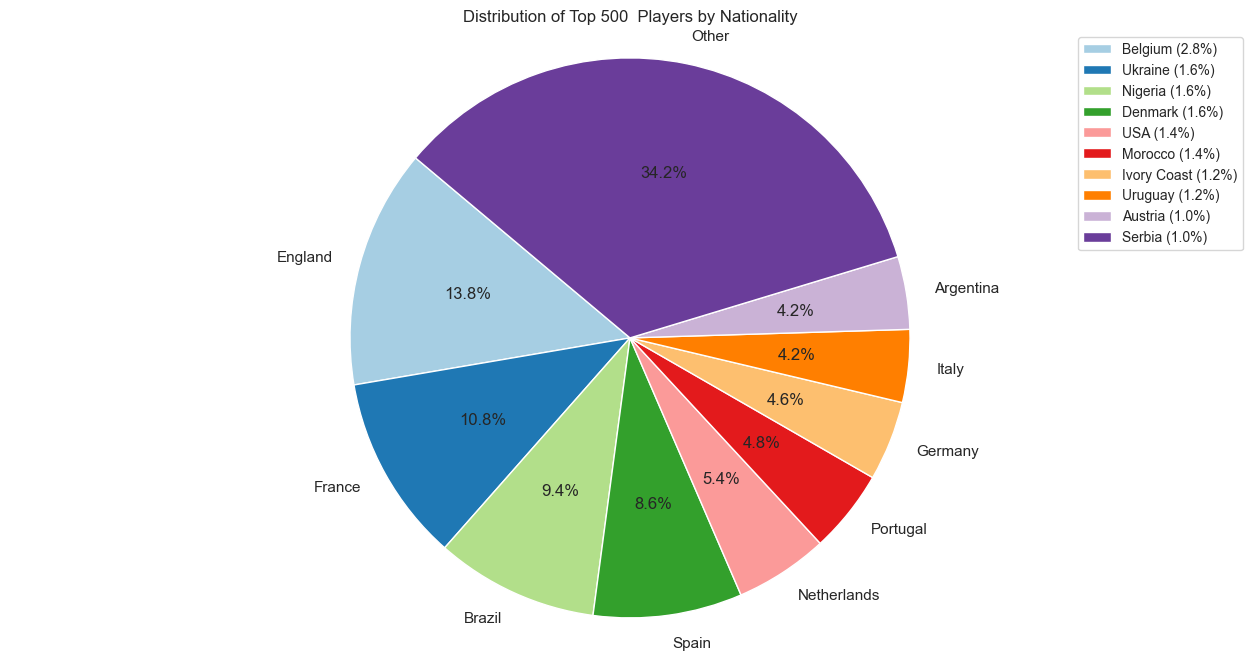

In [87]:

def create_pie_chart_top_n_players_by_country_and_position(n, main_position=None):

    if main_position:
        players_by_position = players_df[players_df['general_position'] == main_position]

    # Sort the players by current_value and select the top N
        top_n_players = players_by_position.nlargest(n, 'current_value')
    else:
        top_n_players = players_df.nlargest(n, 'current_value')

    country_counts = top_n_players['nationality'].value_counts()


    total_players = country_counts.sum()


    threshold_percentage = 3.0

    # get countries with percentages above the threshold
    countries_above_threshold = country_counts[country_counts / total_players * 100 >= threshold_percentage]

    # get countries with percentages below the threshold
    countries_below_threshold = country_counts[country_counts / total_players * 100 < threshold_percentage]

    # group countries below the threshold into 'Others' category
    others_count = countries_below_threshold.sum()
    countries_above_threshold['Other'] = others_count

    plt.figure(figsize=(16, 8))
    patches, texts, autotexts = plt.pie(countries_above_threshold, labels=countries_above_threshold.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(f'Distribution of Top {n} {main_position if main_position else ""} Players by Nationality')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # create a legend for countries below the threshold
    legend_labels = [f'{country} ({count / total_players * 100:.1f}%)' for country, count in countries_below_threshold.items()]
    plt.legend(legend_labels, loc='upper right', fontsize='small')

    plt.show()
top_n = 500
position = "Winger" # None for all position
create_pie_chart_top_n_players_by_country_and_position(n=500, main_position=None)

7. Linear regression to predict the transfer fee based on : market value and age when the transfer completed

In [88]:
# Merge DataFrames on 'player'
merged_df = pd.merge(transfers_df, players_df[['player', 'date_of_birth']], on='player', how='left')


def calculate_age(row):

    season_start_year = int(row['season'])
    birth_date = row['date_of_birth']
    age = season_start_year - birth_date.year

    if birth_date.month > 6:
        age -= 1
    return age


merged_df['age_at_transfer'] = merged_df.apply(calculate_age, axis=1)


In [89]:


X = merged_df[['market_value', 'age_at_transfer']]
Y = merged_df['transfer_fee']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)


Y_pred = model.predict(X_test)

# calculate performance metrics
rmse = root_mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


print("Coefficients:")
print(f"Intercept: {model.intercept_}")
print(f"Market Value Coefficient: {model.coef_[0]}")
print(f"Age Coefficient: {model.coef_[1]}")





Mean Squared Error: 9.654115012873497
R-squared: 0.7008743481022166
Coefficients:
Intercept: 1.095711836351855
Market Value Coefficient: 1.0293640331290934
Age Coefficient: 0.022757513248760988


8. top clubs contributing to the highest raise in total market values,

current_club
Manchester City        1238.0
Arsenal FC             1060.0
Paris Saint-Germain     972.0
Real Madrid             895.0
Bayern Munich           865.0
Chelsea FC              856.0
Liverpool FC            821.0
FC Barcelona            755.0
Tottenham Hotspur       633.0
Manchester United       622.0
Aston Villa             538.0
Inter Milan             532.0
Bayer 04 Leverkusen     495.0
Newcastle United        484.0
AC Milan                463.0
Name: current_value, dtype: float64


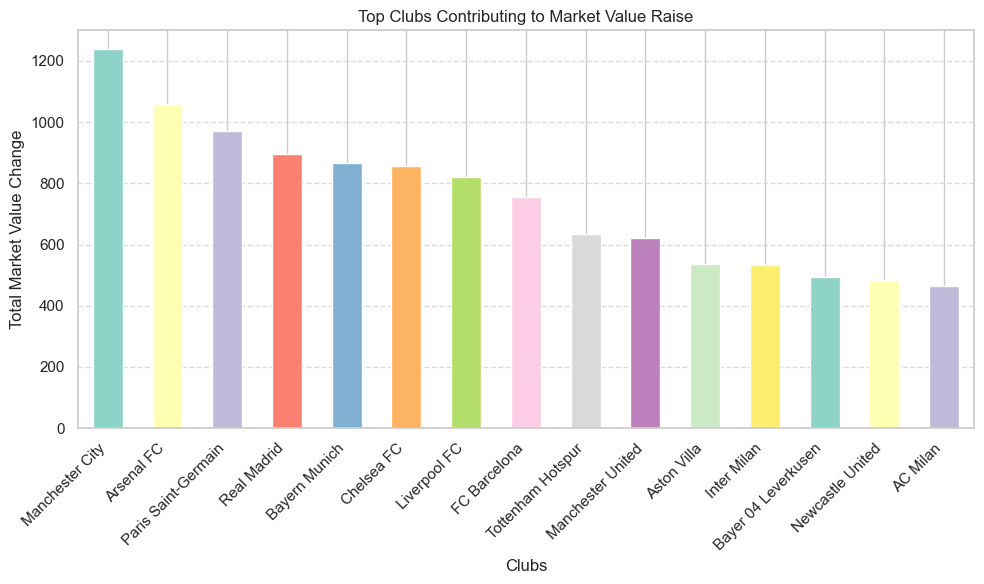

In [91]:
def clubs_with_highest_mv_players(n):

    club_market_value_sum = players_df.groupby(['current_club'])['current_value'].sum()


    clubs_with_highest_raise = club_market_value_sum.nlargest(n)
    return clubs_with_highest_raise

def plot_highest_market_value(clubs_with_highest_raise):
    plt.figure(figsize=(10, 6))

    colors = sns.color_palette('Set3', len(clubs_with_highest_raise))

    clubs_with_highest_raise.plot(kind='bar', color=colors)

    plt.title('Top Clubs Contributing to Market Value Raise')
    plt.xlabel('Clubs')
    plt.ylabel('Total Market Value Change')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

n = 15
top_clubs = clubs_with_highest_mv_players(n)
print(top_clubs)
plot_highest_market_value(top_clubs)
